In [19]:
import numpy as np
import pandas as pd
import statsrat as sr
from statsrat import rw
from statsrat import expr
import random
import nlopt

# IMPORTANT NOTE: the "data" in this example are synthetic, i.e. generated by simulation rather than from
# actual human participants.  This is to avoid any worries privacy issues.

In [7]:
# DEFINE MODELS

# The derived attention model from Le Pelley, Mitchell, Beesley, George and Wills (2016).
drva = rw.model(name = 'drva',
                pred = rw.pred.identity,
                fbase = rw.fbase.elem,
                fweight = rw.fweight.none,
                lrate = rw.lrate.from_aux_feature,
                drate = rw.drate.zero,
                aux = rw.aux.drva)

# CompAct (with only elemental features); Model 4 from Paskewitz and Jones (2020).
CompAct = rw.model(name = 'CompAct',
                   pred = rw.pred.identity,
                   fbase = rw.fbase.elem,
                   fweight = rw.fweight.from_aux_norm,
                   lrate = rw.lrate.from_aux_norm,
                   drate = rw.drate.zero,
                   aux = rw.aux.gradcomp)

In [8]:
# DEFINE THE EXPERIMENT

# Loosely based on Le Pelley and McLaren 2003 (learned predictiveness)

# ADD COMMENTS TO GIVE MORE DETAIL
design = expr.schedule(resp_type = 'choice',
                      stages = {'training': expr.stage(
                                        x_pn = [['a', 'v'], ['b', 'v'], ['a', 'w'], ['b', 'w'], ['c', 'x'], ['d', 'x'], ['c', 'y'], ['d', 'y']],
                                        y = 4*[['cat1'], ['cat2']],
                                        y_psb = ['cat1', 'cat2'],
                                        n_rep = 14),
                                  'transfer': expr.stage(
                                        x_pn = [['a', 'x'], ['b', 'y'], ['c', 'v'], ['d', 'w'], ['e', 'f'], ['g', 'h'], ['i', 'j'], ['k', 'l']],
                                        y = 4*[['cat3'], ['cat4']],
                                        y_psb = ['cat3', 'cat4'],
                                        n_rep = 4),
                                  'test': expr.stage(
                                        x_pn = [['a', 'c'], ['b', 'd'], ['v', 'x'], ['w', 'y'], ['e', 'h'], ['f', 'g'], ['i', 'j'], ['k', 'l']],
                                        y_psb = ['cat3', 'cat4'],
                                        lrn = False,
                                        n_rep = 1)})

rel_irl = expr.oat(schedule_pos = ['design'],
                   behav_score_pos = expr.behav_score(stage = 'test',
                                                      trial_pos = ['a.c -> nothing', 'b.d -> nothing'],
                                                      trial_neg = ['v.x -> nothing', 'w.y -> nothing'],
                                                      resp_pos = ['cat3', 'cat4'],
                                                      resp_neg = ['cat3', 'cat4']))

lrn_pred = expr.experiment(schedules = {'design': design},
                           oats = {'rel_irl': rel_irl})

In [9]:
# Documentation on the read_csv method (used to import data)
help(lrn_pred.read_csv)

Help on method read_csv in module statsrat.expr.experiment:

read_csv(path, x_col, resp_col, resp_map, ident_col=None, conf_col=None, schedule=None, other_info=None, header='infer', n_final=8) method of statsrat.expr.experiment.experiment instance
    Import empirical data from .csv files.
    
    Parameters
    ----------
    path: str
        Path to the .csv files.
    x_col: list
        Names of columns (strings) indicating cues (stimulus
        attributes, i.e. columns of 'x').
    resp_col: list
        Names of columns (strings) indicating responses.
    resp_map: dict
        Maps response names in the raw data to response names in the
        schedule definition.
    ident_col: str or None, optional
        If string, name of column indicating individual identifier
        (the 'ident' variable).  If None, then file names are used
        as 'ident'.  Defaults to None.
    conf_col: str or None, optional
        Name of the column indicating confidence responses (i.e.
     

In [10]:
# IMPORT THE (SYNTHETIC) DATA

(ds, summary) = lrn_pred.read_csv(path = 'data/',
                                  x_col = ['left_stim', 'right_stim'],
                                  resp_col = ['key_press'],
                                  resp_map = {'a': 'cat1', 's': 'cat2', 'd': 'cat3', 'f': 'cat4'},
                                  ident_col = 'subject_id',
                                  conf_col = 'confidence_rating')

In [11]:
# View trial by trial dataset
print(ds)

<xarray.Dataset>
Dimensions:     (ident: 10, t: 152, x_name: 16, y_name: 4)
Coordinates:
  * ident       (ident) <U4 'sim7' 'sim6' 'sim0' 'sim1' ... 'sim2' 'sim9' 'sim8'
  * t           (t) int64 0 1 2 3 4 5 6 7 8 ... 144 145 146 147 148 149 150 151
    t_name      (t) <U4 'main' 'main' 'main' 'main' ... 'main' 'main' 'main'
    ex          (ident, t) <U3 'd.y' 'a.w' 'd.x' 'b.w' ... 'w.y' 'b.d' 'f.g'
    trial       (t) int64 0 1 2 3 4 5 6 7 8 ... 144 145 146 147 148 149 150 151
    trial_name  (ident, t) <U14 'd.y -> cat2' 'a.w -> cat1' ... 'f.g -> nothing'
    stage       (t) int64 0 0 0 0 0 0 0 0 0 0 0 ... 8 8 16 16 16 16 16 16 16 16
    stage_name  (t) <U8 'training' 'training' 'training' ... 'test' 'test'
  * x_name      (x_name) <U1 'a' 'b' 'c' 'd' 'e' 'f' ... 'k' 'l' 'v' 'w' 'x' 'y'
  * y_name      (y_name) <U4 'cat1' 'cat2' 'cat3' 'cat4'
    time        (t) int64 0 1 2 3 4 5 6 7 8 ... 144 145 146 147 148 149 150 151
Data variables:
    x           (ident, t, x_name) float64 0.0

In [12]:
# View summary dataframe
print(summary)

       training_last8_pct_correct  transfer_last8_pct_correct  rel_irl
ident                                                                 
sim7                        100.0                       100.0      1.0
sim6                        100.0                       100.0      4.0
sim0                        100.0                       100.0      2.0
sim1                        100.0                        75.0      0.0
sim4                        100.0                       100.0      1.0
sim5                         62.5                        25.0      0.0
sim3                        100.0                       100.0      2.0
sim2                        100.0                        62.5      2.5
sim9                         87.5                        75.0     12.5
sim8                        100.0                       100.0     -3.0


In [23]:
# Take a random subset of the imported data to test optimization algorithms
# and figure out how long optimization takes
selection = random.sample(list(ds['ident'].values), k = 5)
subset = ds.loc[{'ident': selection}].copy()

Fitting 1 of 5 (20.0%)
Fitting 2 of 5 (40.0%)
Fitting 3 of 5 (60.0%)
Fitting 4 of 5 (80.0%)
Fitting 5 of 5 (100.0%)
Fitting 1 of 5 (20.0%)
Fitting 2 of 5 (40.0%)
Fitting 3 of 5 (60.0%)
Fitting 4 of 5 (80.0%)
Fitting 5 of 5 (100.0%)
Fitting 1 of 5 (20.0%)
Fitting 2 of 5 (40.0%)
Fitting 3 of 5 (60.0%)
Fitting 4 of 5 (80.0%)
Fitting 5 of 5 (100.0%)
Fitting 1 of 5 (20.0%)
Fitting 2 of 5 (40.0%)
Fitting 3 of 5 (60.0%)
Fitting 4 of 5 (80.0%)
Fitting 5 of 5 (100.0%)
Fitting 1 of 5 (20.0%)
Fitting 2 of 5 (40.0%)
Fitting 3 of 5 (60.0%)
Fitting 4 of 5 (80.0%)
Fitting 5 of 5 (100.0%)
  ident   atn_min     lrate  resp_scale  prop_log_post model  global_time  \
0  sim1  0.522294  0.065446    9.548651     -48.105614  drva           10   
1  sim6  0.339555  0.722820    9.226449     -11.825323  drva           10   
2  sim4  0.827103  0.209932    8.442915     -15.718888  drva           10   
3  sim8  0.826129  0.321281    2.919117     -45.053496  drva           10   
4  sim9  0.772281  0.733297    1.34

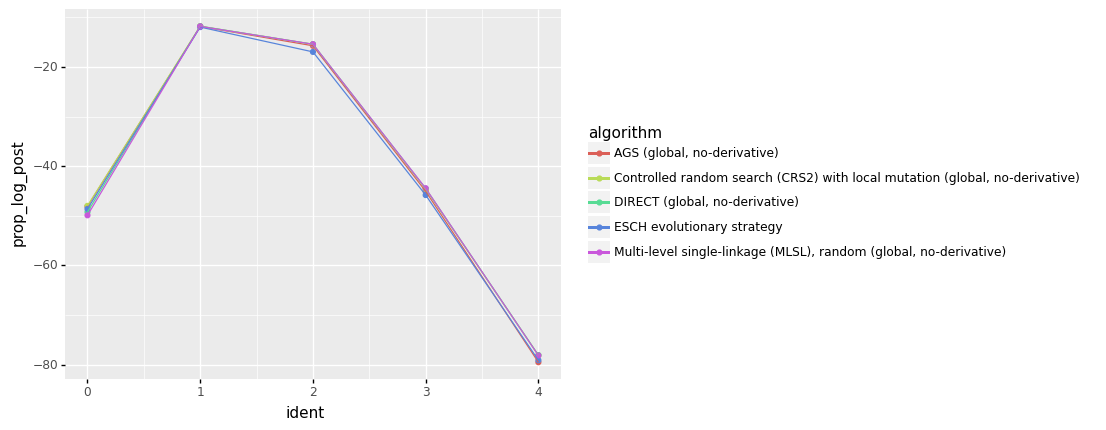

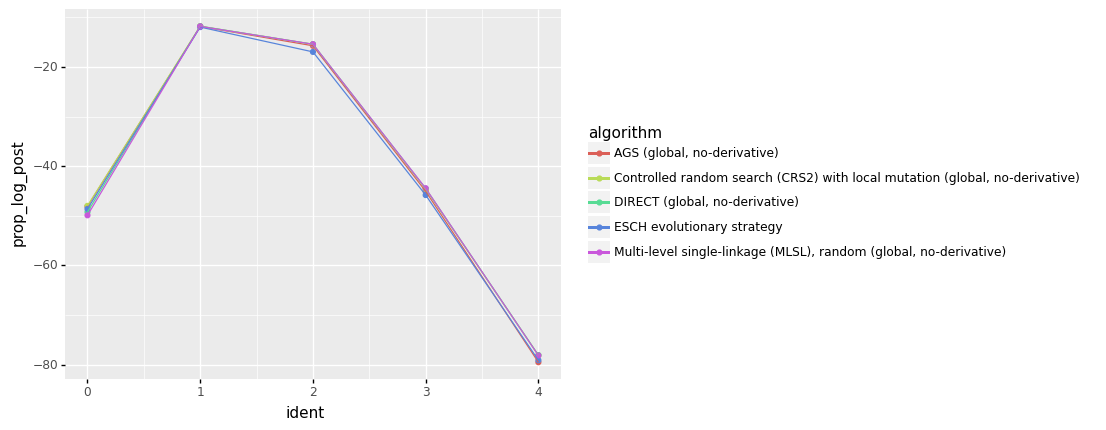

<ggplot: (8778753410196)>

In [24]:
# FIRST MODEL (DERIVED ATTENTION)

# Test different optimization algorithms (on a subset of data)
compare_drva = sr.fit_algorithm_plots(ds = subset,
                                      model = drva,
                                      time_interval_size = 10,
                                      n_time_intervals = 1,
                                      algorithm_list = [nlopt.GN_AGS, nlopt.GN_CRS2_LM, nlopt.GN_DIRECT, nlopt.GN_ESCH, nlopt.GN_MLSL])
print(compare_drva['df'])
compare_drva['plot']

Fitting 1 of 5 (20.0%)
Fitting 2 of 5 (40.0%)
Fitting 3 of 5 (60.0%)
Fitting 4 of 5 (80.0%)
Fitting 5 of 5 (100.0%)
Fitting 1 of 5 (20.0%)
Fitting 2 of 5 (40.0%)
Fitting 3 of 5 (60.0%)
Fitting 4 of 5 (80.0%)
Fitting 5 of 5 (100.0%)
Fitting 1 of 5 (20.0%)
Fitting 2 of 5 (40.0%)
Fitting 3 of 5 (60.0%)
Fitting 4 of 5 (80.0%)
Fitting 5 of 5 (100.0%)
Fitting 1 of 5 (20.0%)
Fitting 2 of 5 (40.0%)
Fitting 3 of 5 (60.0%)
Fitting 4 of 5 (80.0%)
Fitting 5 of 5 (100.0%)
  ident   atn_min     lrate  resp_scale  prop_log_post model  global_time  \
0  sim1  0.500000  0.167333    4.259407     -49.250480  drva            5   
1  sim6  0.463037  0.500000    9.813852     -11.796969  drva            5   
2  sim4  0.980519  0.167333    9.443556     -15.437370  drva            5   
3  sim8  0.980519  0.204296    3.395383     -44.539528  drva            5   
4  sim9  0.426074  0.943556    1.297037     -78.603690  drva            5   
0  sim1  0.610889  0.056444    8.332667     -48.235921  drva           10 

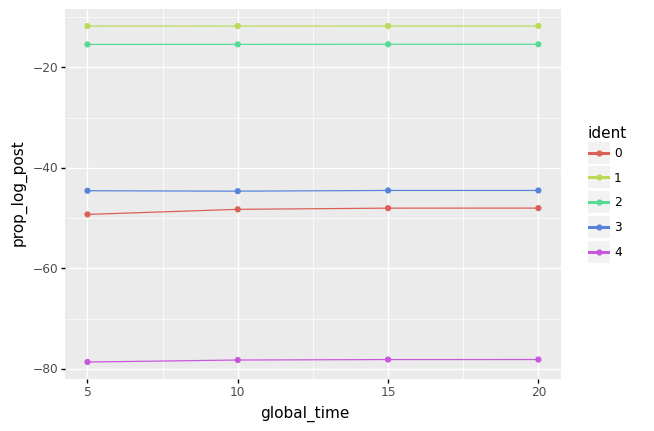

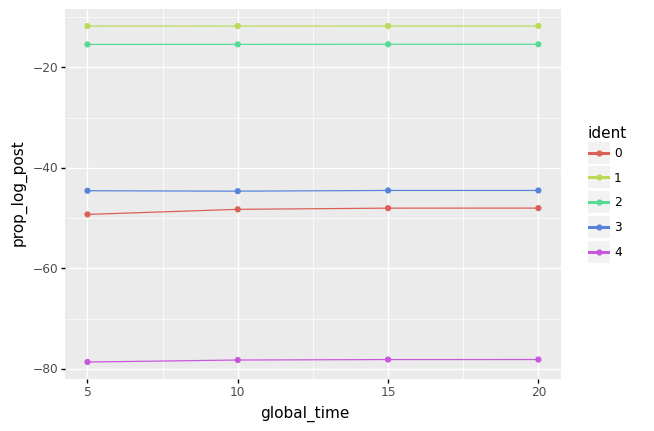

<ggplot: (8778755403786)>

In [28]:
# Determine how long the optimization algorithm needs to run (subset of data)
convg_drva = sr.fit_algorithm_plots(ds = subset,
                                    model = drva,
                                    time_interval_size = 5,
                                    n_time_intervals = 4,
                                    algorithm = nlopt.GN_DIRECT)
print(convg_drva['df'])
convg_drva['plot']

In [11]:
# Fit the model to the data (full dataset)


Fitting 1 of 5 (20.0%)
Fitting 2 of 5 (40.0%)
Fitting 3 of 5 (60.0%)
Fitting 4 of 5 (80.0%)
Fitting 5 of 5 (100.0%)
Fitting 1 of 5 (20.0%)
Fitting 2 of 5 (40.0%)
Fitting 3 of 5 (60.0%)
Fitting 4 of 5 (80.0%)
Fitting 5 of 5 (100.0%)
Fitting 1 of 5 (20.0%)
Fitting 2 of 5 (40.0%)
Fitting 3 of 5 (60.0%)
Fitting 4 of 5 (80.0%)
Fitting 5 of 5 (100.0%)
Fitting 1 of 5 (20.0%)
Fitting 2 of 5 (40.0%)
Fitting 3 of 5 (60.0%)
Fitting 4 of 5 (80.0%)
Fitting 5 of 5 (100.0%)
Fitting 1 of 5 (20.0%)
Fitting 2 of 5 (40.0%)
Fitting 3 of 5 (60.0%)
Fitting 4 of 5 (80.0%)
Fitting 5 of 5 (100.0%)
  ident   atn_min     lrate  resp_scale  prop_log_post model  global_time  \
0  sim1  0.522294  0.065446    9.548651     -48.105614  drva           20   
1  sim6  0.339555  0.722820    9.226449     -11.825323  drva           20   
2  sim4  0.990350  0.159496    9.905025     -15.412631  drva           20   
3  sim8  0.826129  0.321281    2.919117     -45.053496  drva           20   
4  sim9  0.333220  0.989863    1.46

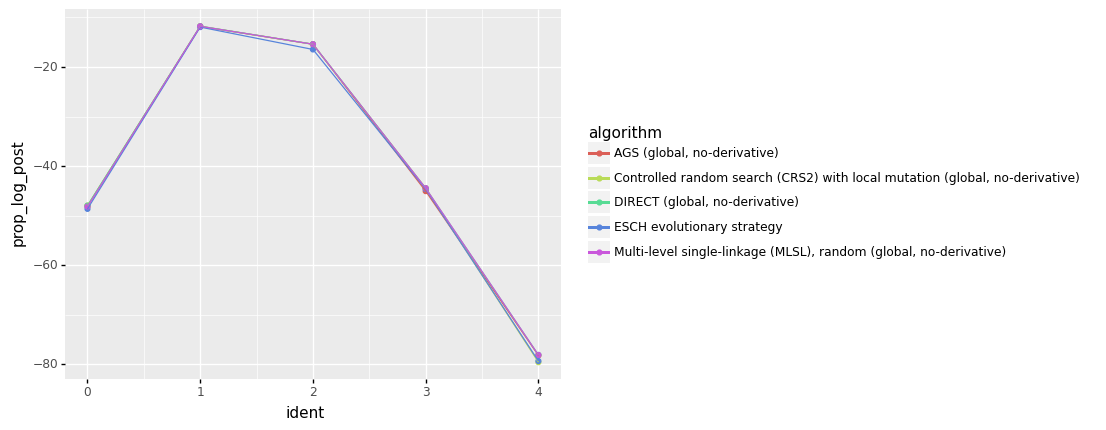

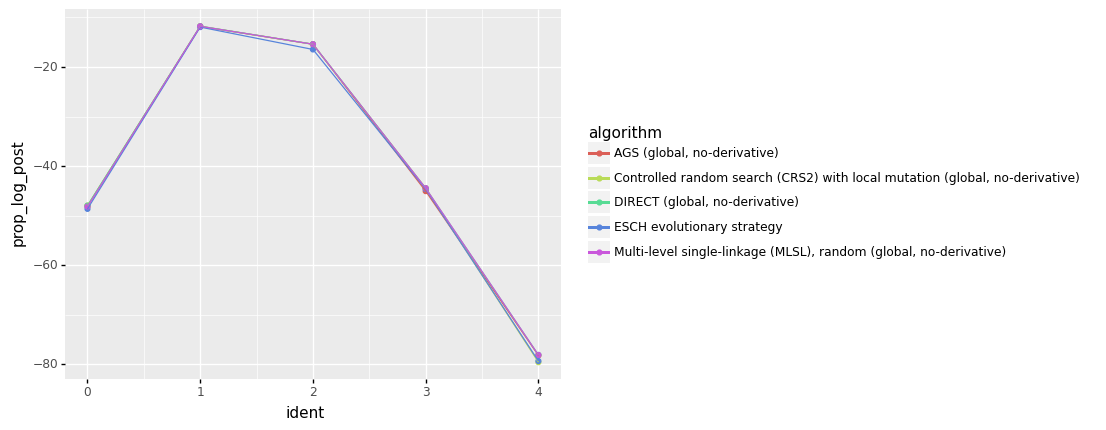

<ggplot: (8778753960521)>

In [26]:
# SECOND MODEL (COMPACT)

# Test different optimization algorithms (on a subset of data)
compare_CompAct = sr.fit_algorithm_plots(ds = subset,
                                      model = drva,
                                      time_interval_size = 10,
                                      n_time_intervals = 1,
                                      algorithm_list = [nlopt.GN_AGS, nlopt.GN_CRS2_LM, nlopt.GN_DIRECT, nlopt.GN_ESCH, nlopt.GN_MLSL])
print(compare_CompAct['df'])
compare_CompAct['plot']

Fitting 1 of 5 (20.0%)
Fitting 2 of 5 (40.0%)
Fitting 3 of 5 (60.0%)
Fitting 4 of 5 (80.0%)
Fitting 5 of 5 (100.0%)
Fitting 1 of 5 (20.0%)
Fitting 2 of 5 (40.0%)
Fitting 3 of 5 (60.0%)
Fitting 4 of 5 (80.0%)
Fitting 5 of 5 (100.0%)
Fitting 1 of 5 (20.0%)
Fitting 2 of 5 (40.0%)
Fitting 3 of 5 (60.0%)
Fitting 4 of 5 (80.0%)
Fitting 5 of 5 (100.0%)
Fitting 1 of 5 (20.0%)
Fitting 2 of 5 (40.0%)
Fitting 3 of 5 (60.0%)
Fitting 4 of 5 (80.0%)
Fitting 5 of 5 (100.0%)
  ident   atn_min     lrate  resp_scale  prop_log_post model  global_time  \
0  sim1  0.389111  0.155012    5.000000     -49.317993  drva            5   
1  sim6  0.500000  0.500000    9.443556     -11.820490  drva            5   
2  sim4  0.943556  0.167333    9.443556     -15.498637  drva            5   
3  sim8  0.980519  0.204296    3.518815     -44.624310  drva            5   
4  sim9  0.389111  0.980519    1.667333     -78.670405  drva            5   
0  sim1  0.500000  0.155012    4.259407     -49.207139  drva           10 

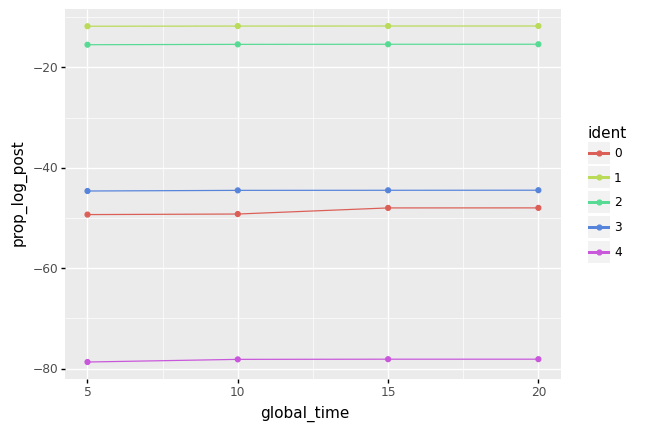

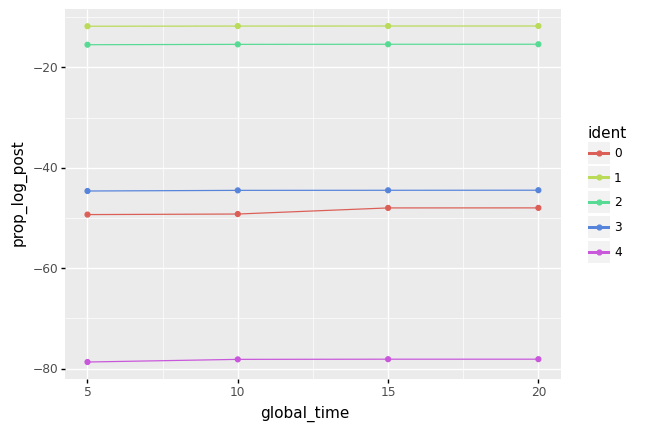

<ggplot: (8778755775217)>

In [29]:
# Determine how long the optimization algorithm needs to run (subset of data)
convg_CompAct = sr.fit_algorithm_plots(ds = subset,
                                       model = drva,
                                       time_interval_size = 5,
                                       n_time_intervals = 4,
                                       algorithm = nlopt.GN_DIRECT)
print(convg_CompAct['df'])
convg_CompAct['plot']

In [14]:
# Fit the model to the data (full dataset)


In [15]:
# Compare AIC (Akaike Information Criterion) values
# These are based on a log-likelihood but penalize the number of free parameters
# Higher is better
